<a href="https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/Session5/Fourth_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Convolutional Neural Network with less than 15000 parameters to achieve a validation accuracy of 99.4 or more for MNIST dataset 


The target is to build a deep learning CNN model with as little parameters as possible and at the same time achieve a high validation accuracy of 99.4 or more . The low parameter count becomes important when deploying the model in memory constrained devices used in edge computing . MNIST is one of the more popular (and simpler) datasets to begin your journey in Vision based Deep learning. We will use this MNIST dataset for this exercise. 

We will build the model step by step . Broadly speaking we will follow these steps 

1. Decide on the basic architecture for the network 
2. Fine tune parameters to comply with the 15000 limit
3. Add improvements to the network using Batch Normalization 
4. See if we can converge faster while learning by using Dropouts to overcome overfitting ,higher   learning rates, etc 

We are now at step 4 .

In the [first iteration](https://github.com/ravindrabharathi/Project1/blob/master/Session4/First_DNN.ipynb)  we fixed the basic architecture without bothering too much about the number of parameters . 

In the [second iteration](https://colab.research.google.com/github/ravindrabharathi/Project1/blob/master/Session4/Second_DNN.ipynb) we brought down the number of parameters to within the required limit to around 11k .

In the [third iteration](https://github.com/ravindrabharathi/Project1/blob/master/Session4/Third_DNN.ipynb) we added BatchNormalization and brought the validation accuracy to 99.41 

In this iteration we will tune the performance of the model by adding regularization via Dropouts.

Basically Dropout helps in regularizing a network against overrfitting by randomly dropping a proportion of the signals while training. The absence of some of the units force the rest of the active units to learn better . The concept of Dropout was first present in this paper titled [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://jmlr.org/papers/v15/srivastava14a.html). 

![dropouts](https://raw.githubusercontent.com/ravindrabharathi/eip3/master/images/dropouts.png)

We will drop about 10% of the signals after each convolution layer (ecluding the transition blocks and the last layer) .

Since Dropouts are being used , we could also try higher learning rates . We will start with a higher learning rate than the default of 0.001 for Adam and then use a learning rate scheduler to reduce the learning rate progressively 

We will also try an increase in Batch size (128 from 32 ) since it would be better for the model to see a larger sampling of images per training step 

###Import necessary libraries / modules
Import numpy library for array/ matrix operations

Import Sequential Model from keras/models for building the model

Import Conv2D , Activation , Flatten , BatchNormalization, MaxPooling2D from keras/layers 

Import np_utils module from keras/utils for numpy related helper functions

Import mnist dataset containing hand-written digits images from keras.datasets

In [0]:
import numpy as np

from keras.models import Sequential,load_model
from keras.layers import Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import np_utils

from keras.datasets import mnist

Using TensorFlow backend.


### Load pre-shuffled MNIST data into train and test sets

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

###print the shape of training data and also inspect the first image using matplotlib

(60000, 28, 28)


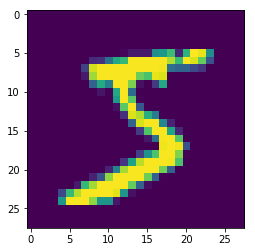

In [0]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

####Reshape the training and test dataset to include the channel information.In this case it is a greyscale image and so there is 1 channel . the image data was read in as a 28x28 numpy array and is now reshaped to 28x28x1

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

###Cast training data as float32 and normalize/re-scale the values such that they are between 0 and 1 instead of 0 and 255

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

###inspect the first 10 training class labels . They will be some number between 0 and 9 representing the hand-written digit in the corresponding Training data. Each of 0 to 9 represents a class

In [0]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

####One hot encoding of training and test class labels : Convert 1-dimensional class arrays to 10-dimensional class matrices

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

###Define a ModelCheckPoint callback which will be called at the end of every training epoch . We will use this callback function to save the model whenever vallidation accuracy improves . We do this so that we can load and use the best model for further predictions after training 

In [0]:
from keras.callbacks import ModelCheckpoint
  
#chkpoint_model=ModelCheckpoint("/gdrive/My Drive/EVA/Session3/model_customv1_mnist_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 

chkpoint_model=ModelCheckpoint("model_custom_v1_mnist_best.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 



#Building the model version 4

In version 4 of the model we will try and improve the performance of the model by adding Dropout at the end of each convolution block . We will use a dropout of 10%.

We will also use an increased initial learning rate that is progressively reduced using a scheduler 

We will increase training batch size to 128



In [0]:
# to get a certain degeree of predictability when generating random numbers,
# set a random seed to initialize the pseudo-random number generator 
np.random.seed(seed=42)  

# instantiate a sequential model
model = Sequential()

# add the first convolution layer - 10 numbers of 3x3 filters , 
#This layer sees the input image of 28x28 x 1 channel . 

model.add(Conv2D(10, (3, 3), input_shape=(28,28,1), use_bias=False))  # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization  
model.add(Activation('relu'))    # use ReLU activation function .
model.add(Dropout(0.1))  #add dropout

# Now the global receptive field is 3 x 3 

# First Convolution Block
# Block1 conv layer 1 - 12 filters of shape  3x3x10 
# input from previous layer is 26 x 26 x 10 . 

## Block 1

model.add(Conv2D(12, 3, use_bias=False))  # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization 
model.add(Activation('relu'))    # use ReLU activation function .
model.add(Dropout(0.1))   #add dropout

#Global receptive field is 5x5

# Add convolution layer - 16 filters of shape  3x3x12 
#input from previous layer is 24 x 24 x 12 . 

model.add(Conv2D(16, 3, use_bias=False))  # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization
model.add(Activation('relu'))    # use ReLU activation function .
model.add(Dropout(0.1))    #add dropout

#Global receptive field is 7x7

##  Transition block 

# Perform 2x2 max pooling  . 
#Input from previous layer is 22 x 22 X 16 

model.add(MaxPooling2D(2,2))


# After max pooling , 2D spatial dimension reduces by half , i.e it becomes 11 x 11 . 
# Maxpooling (withpool size 2 and stride 1) doubles receptive field . 
# So global receptive field after max pooling is 14 x 14

# add 1x1 convolution to reduce the channel numbers to 10 

model.add(Conv2D(10, 1, use_bias=False))  # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization 
model.add(Activation('relu'))    # use ReLU activation function .


#Convolution Block 2

# Add convolution layer - 12 filters of shape 3x3x10
#input from transition layer is 11 x 11 x 10 .  

model.add(Conv2D(12, 3,  use_bias=False))  # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization
model.add(Activation('relu'))    # use ReLU activation function .
model.add(Dropout(0.1))   #add dropout

#Global receptive field is now 16 x 16 

# Add convolution layer - 16 filters of shape 3x3x12 
#input coming from previous layer is 9 x 9 x 12 . 

model.add(Conv2D(16, 3,  use_bias=False)) # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization 
model.add(Activation('relu'))    # use ReLU activation function .
model.add(Dropout(0.1))

#  Global receptive field is now 18 x 18 


# Add 1x1 convolution to reduce number of channels to 10  
#input coming from previous layer is 7 x 7 x 16 .

model.add(Conv2D(10, 1,  use_bias=False))  # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization 
model.add(Activation('relu'))    # use ReLU activation function .


#Global receptive field is now 18 x 18 

# Last layer :  Add convolution layer - 10 filters of shape 7x7x10 
#input coming from previous layer is 7 x 7 x 10 .

model.add(Conv2D(10, 7,  use_bias=False))  # remove bias param by setting it to false 
model.add(BatchNormalization())  #add Batch normalization
# Note absence of ReLU activation here 


model.add(Flatten())  # Flatten the 2d array to 1d input for the softmax activation 
model.add(Activation('softmax'))   # Softmax activation to out class probabilities 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 10)        90        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 10)        40        
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 12)        1080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 12)        48        
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 12)        0         
__________

In [0]:
# define a learning rate scheduler . We will use a simple scheduler that reduces the lr by 10% every 3 epochs subject to a minimum lr of 0.0005 
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  if (epoch%3==0 and epoch):
    new_lr = max(0.9*lr,0.0005) 
  else:
    new_lr=lr
  
  return round(new_lr, 10)
  
 



In [0]:
#start with a higher lr of 0.003 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

In [0]:
#increase batch size to 128 and traun for 60 epochs 
model.fit(X_train, Y_train, validation_data=(X_test,Y_test),batch_size=128, epochs=60, verbose=1, callbacks=[chkpoint_model,LearningRateScheduler(scheduler, verbose=1)])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 9s 147us/step - loss: 0.3796 - acc: 0.9341 - val_loss: 0.1291 - val_acc: 0.9807

Epoch 00001: val_acc improved from -inf to 0.98070, saving model to model_custom_v1_mnist_best.h5
Epoch 2/60

Epoch 00002: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 7s 112us/step - loss: 0.1190 - acc: 0.9780 - val_loss: 0.0830 - val_acc: 0.9858

Epoch 00002: val_acc improved from 0.98070 to 0.98580, saving model to model_custom_v1_mnist_best.h5
Epoch 3/60

Epoch 00003: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 6s 103us/step - loss: 0.0781 - acc: 0.9832 - val_loss: 0.0394 - val_acc: 0.9902

Epoch 00003: val_acc improved from 0.98580 to 0.99020, saving model to model_custo

###We trained the model for 60 epochs and it has a max validation accuracy of 99.52. 

###We also observe that the due to the dropouts the training accuracy was lower than the validation accuracy in the beginning before rising higher. This is because the the dropped units are only during training and will participate fully in the validation phase. 

###We also notice that the gap between training and validation accuracy is lesser due to the effect of dropouts 

### The required 99.4 validation accuracy was reached faster than the previous iteration - in epoch 14.


### Let us load the Model with best validation accuracy and print the evaluation score 

In [0]:
model=load_model("model_custom_v1_mnist_best.h5")

In [0]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [0]:
print(score)

[0.01742733436343842, 0.9952]


### Predict the classes using model.predict and print predicted probabilities and categorical array for True test classes 

In [0]:
y_pred = model.predict(X_test)

In [0]:
print(y_pred[:9])
print(Y_test[:9])

[[1.57381589e-06 1.39165422e-05 9.62392164e-07 2.11704969e-06
  2.87080047e-06 9.83216296e-07 1.04582654e-07 9.99976993e-01
  7.96954893e-08 3.55278502e-07]
 [2.93556468e-06 1.17223692e-06 9.99987125e-01 2.98503522e-07
  4.99096586e-07 1.09032838e-09 7.16115392e-06 2.45385678e-07
  5.51291180e-07 2.63949342e-08]
 [2.73492390e-07 9.99898791e-01 1.28019352e-07 1.34703976e-06
  2.62308026e-06 8.33929371e-05 5.30659645e-06 3.39038070e-06
  3.75394393e-06 1.05119875e-06]
 [9.99887228e-01 1.14009947e-06 6.83825817e-07 1.45662069e-08
  5.48336686e-07 1.84093807e-07 7.84729782e-05 7.45014540e-06
  9.23682251e-07 2.32167768e-05]
 [1.52993948e-07 1.25076594e-05 3.82066929e-07 4.78601862e-07
  9.99984622e-01 6.68860256e-09 4.43562271e-07 2.04720720e-07
  7.10572237e-07 5.65000903e-07]
 [4.52342675e-07 9.99972224e-01 1.11369343e-06 1.55494590e-07
  7.03976593e-06 4.42121109e-06 1.22046720e-06 1.23034270e-05
  4.50615715e-07 5.30906448e-07]
 [3.28050892e-10 1.26155066e-06 1.16197718e-07 4.88288610e

### Let us visualize some of the filters in the first convolution layer 'conv2d_1'

In [0]:
# form a layer dictionary {name : layer} of all layers in the model 

layer_dict = dict([(layer.name, layer) for layer in model.layers])  

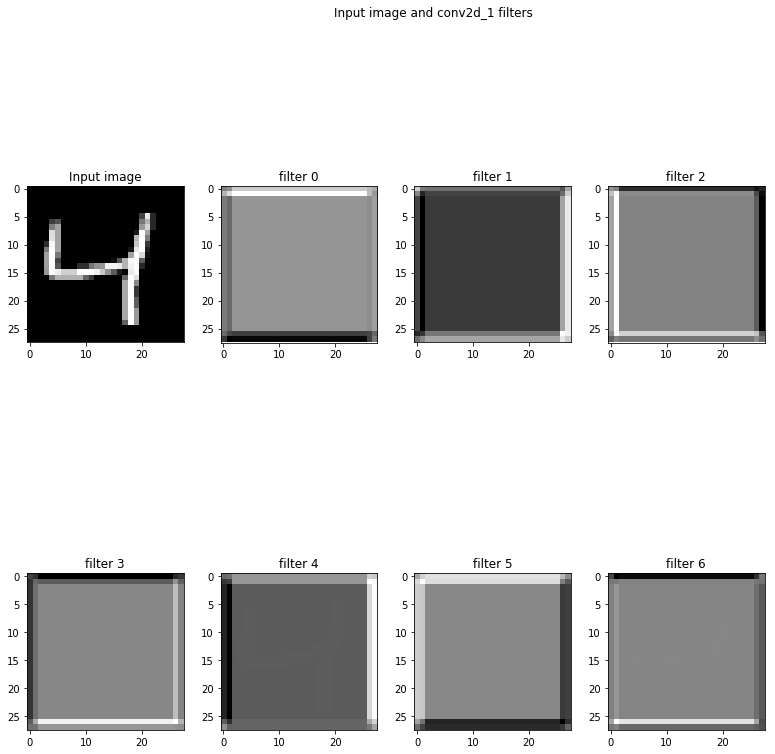

In [0]:
 # use matplotlib to visualize the filter arrays 
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_1'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    elif layer_output.shape[3] >= 8:
        plot_x, plot_y = 2, 4   
    else:
        
        plot_x, plot_y = 2, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    
    ax[0,0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0,0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x,y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x,y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

### We have now completed the fourth step in building our model and we have reached a max validation accuracy of 99.52 in 60 epochs 

###We used Dropouts , a very simplified learning rate scheduler and a larger batch size in this iteration to improve the model and croosed the 99.4 validation accuracy in the 14th epoch. 

###We could improve this model further by using a cleaner and more efficient way of sending the input to the softmax layer by using Global Average Pooling . We did not use SGD optimizer as it might have converged slower than Adam optimizer.  A better learning rate scheduler which took into account whether accuracy was increasing before changing the learning rate would have helped more .

